<a href="https://colab.research.google.com/github/GregoryG3/Thesis/blob/main/2_Transformers_model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
# !pip install -U transformers
!pip install -U accelerate

# !pip install transformers[torch]
# !pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
import pandas as pd
import numpy as np
import random

import os
from google.colab import drive
from os.path import join

import accelerate
from transformers import (AutoTokenizer, Trainer, TrainingArguments, pipeline,
                          AutoModelForSequenceClassification, BertForSequenceClassification,
                          BertTokenizer, AdamW, XLNetTokenizer, XLNetForSequenceClassification,
                          RobertaTokenizer, RobertaForSequenceClassification, AutoModelForSeq2SeqLM)
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm

from sklearn.metrics import (f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Finetuning models

## Load manual coded data

In [5]:
drive.mount('/content/drive')
PROJECT_DIR = "/content/drive/MyDrive/Thesis/Data"
FEEDBACK_DIR = join(PROJECT_DIR, "Feedback data")
PROCESSED_DIR = join(PROJECT_DIR, "Processed")

Mounted at /content/drive


Load the manually coded dataset:

In [6]:
df = pd.read_csv(join(PROJECT_DIR,"Annotation data/manual_coding_majority_vote_2000_texts.csv"), encoding='latin1')

# replace the NA from one empty text
df.at[1726, 'comment'] = " "

# delete columns
col_delete = ['t_other', 'a_seller', 'a_buyers', 'a_platform', 'a_unclear',
              'a_other', 'sub_obj', 'emo_une', 'm_other']
df = df.drop(columns=col_delete)

In [5]:
df.head(4)

,comment,global_id,t_communication,t_payment,t_refund,t_price,t_value,t_shipping,t_product,t_feedback,...,t_generic,t_overall,pos_neg,m_help_other_buyer,m_avoid_harm_seler,m_help_seller,m_rew_pun_seller,m_reach_seller,m_express_emo,m_share_facts
0,great vendor,ao1003730,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
1,good shit. cone pretty small conpared to stock...,ao1005428,0,0,0,0,0,0,1,0,...,0,0,3,0,0,0,0,0,0,1
2,very nice,ao1007033,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,0,0,0,0
3,arrived in 3 days! Top quality product. this...,ao1008851,0,0,0,0,0,1,1,0,...,0,0,3,0,0,0,1,0,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             2000 non-null   object
 1   global_id           2000 non-null   object
 2   t_communication     2000 non-null   int64 
 3   t_payment           2000 non-null   int64 
 4   t_refund            2000 non-null   int64 
 5   t_price             2000 non-null   int64 
 6   t_value             2000 non-null   int64 
 7   t_shipping          2000 non-null   int64 
 8   t_product           2000 non-null   int64 
 9   t_feedback          2000 non-null   int64 
 10  t_vendor            2000 non-null   int64 
 11  t_generic           2000 non-null   int64 
 12  t_overall           2000 non-null   int64 
 13  pos_neg             2000 non-null   int64 
 14  m_help_other_buyer  2000 non-null   int64 
 15  m_avoid_harm_seler  2000 non-null   int64 
 16  m_help_seller       2000

In [7]:
df.shape

(2000, 21)

Create the summary table

In [27]:
selected_col = df.drop(columns=['comment', 'global_id', 'pos_neg'])

summary_table = selected_col.apply(lambda x: pd.Series([x.value_counts().get(0, 0), x.value_counts().get(1, 0)], index=['0', '1']))
summary_table = summary_table.transpose()
summary_table

,0,1
t_communication,1646,354
t_payment,1925,75
t_refund,1904,96
t_price,1948,52
t_value,1888,112
t_shipping,984,1016
t_product,1111,889
t_feedback,1940,60
t_vendor,1657,343
t_generic,1874,126


In [30]:
df['pos_neg'].value_counts()

pos_neg
3    937
1    743
2    320
Name: count, dtype: int64

## Preprocessing

Encode the labels

In [7]:
df['pos_neg'] = df['pos_neg'].map({3:'positive', 2: 'neutral', 1: 'negative'})

In [8]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['pos_neg'])

In [9]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

Split Dataset to Train-Val-Test

In [14]:
train_df_, val_df = train_test_split(df,
                                    test_size=0.10,
                                    random_state=123)

train_df, test_df = train_test_split(train_df_,
                                    test_size=0.10,
                                    random_state=123)


# Check the sizes of the sets
print("Size of training set:", len(train_df))
print("Size of validation set:", len(val_df))
print("Size of test set:", len(test_df))
print("Shape of training set:", train_df.shape)

Size of training set: 1620
Size of validation set: 200
Size of test set: 180
Shape of training set: (1620, 22)


Setting device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining the performance metrics

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Create MyDataset - preprocessed dataset

In [17]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}

        # Dodaj klucz 'labels' do elementu, nawet jeśli są None
        item['labels'] = self.labels[idx] if self.labels is not None else None

        return item

## Sentiment analyses

### 1 Baseline

As a baseline we randomly predict positive, negative or neutral

In [ ]:
labels = [0, 1, 2]
label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

random.seed(12345)

baseline_pred = [random.choice(labels) for _ in range(len(test_df))]

In [ ]:
# F1 score
f1_test = f1_score(baseline_pred, test_df['label'], average='macro', labels=labels)

print("F1 Score on test data:", f1_test)

F1 Score on test data: 0.2843893024538186


In [ ]:
# F1 score for each class
for label, score in zip(labels, f1_score(baseline_pred, test_df['label'], labels=labels, average=None)):
    print(f"F1 score for {label_names[label]}: {score}")

F1 score for negative: 0.3741935483870968
F1 score for neutral: 0.18666666666666668
F1 score for positive: 0.29230769230769227


Text(0.5, 1.0, 'Confusion Matrix for Baseline model')

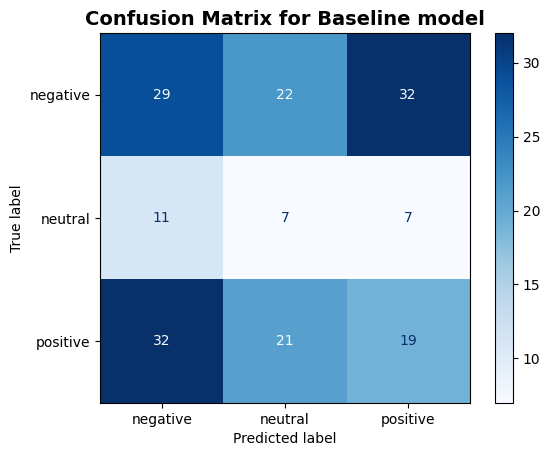

In [ ]:
# Confusion Matrix

baseline_cm = confusion_matrix(y_pred=baseline_pred,
                                y_true= test_df['label'],
                                labels=np.unique(test_df['label']))

ConfusionMatrixDisplay(confusion_matrix=baseline_cm,
                       display_labels=[label_names[label] for label in np.unique(test_df['label'])]
                       ).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Baseline model', fontsize=14, fontweight='bold')

### 2 BERT

Tokenizing:

In [ ]:
# create tokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [ ]:
# here 'label' are encoded sentiment values:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [ ]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=3)
         .to(device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 32
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Finetuning the model

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.737200,0.573664,0.755000,0.615794,0.755000,0.676905
2,0.415100,0.520993,0.805000,0.805826,0.805000,0.791427
3,0.290200,0.449928,0.825000,0.810183,0.825000,0.809096


In [ ]:
preds_output = trainer.predict(val_dataset)

In [ ]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric       Value
0                test_loss    0.449928
1            test_accuracy    0.825000
2           test_precision    0.810183
3              test_recall    0.825000
4                  test_f1    0.809096
5             test_runtime    0.940100
6  test_samples_per_second  212.749000
7    test_steps_per_second    7.446000


Evaluation on test dataset

In [ ]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [ ]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.864     0.916     0.889        83
           1      0.500     0.280     0.359        25
           2      0.923     1.000     0.960        72

    accuracy                          0.861       180
   macro avg      0.762     0.732     0.736       180
weighted avg      0.837     0.861     0.844       180



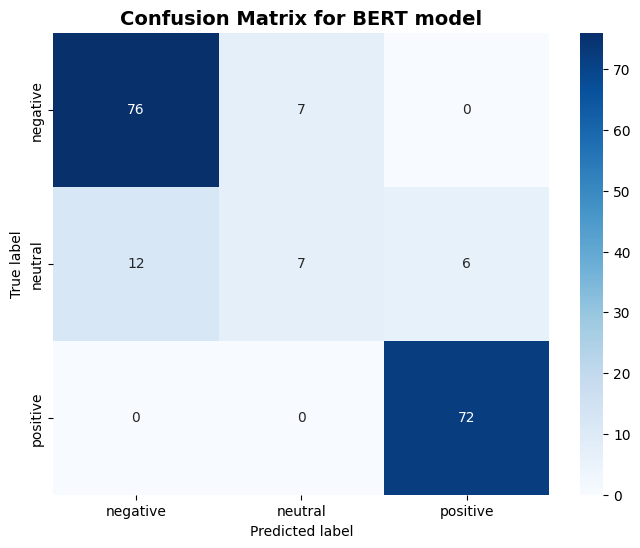

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix BERT for Text polarity', fontsize=12, fontweight='bold')
plt.show()


### 3 RoBERTa

Tokenizing and Encoding the Data

In [35]:
# create tokenizer
model_ckpt = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [36]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [37]:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [38]:
model = (RobertaForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)
         .to(device))

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [43]:
batch_size = 32
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


Finetuning the model

In [44]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.712100,0.474020,0.805000,0.808691,0.805000,0.804963
2,0.328000,0.548166,0.805000,0.808438,0.805000,0.796977
3,0.194600,0.439007,0.865000,0.859849,0.865000,0.858402


In [45]:
preds_output = trainer.predict(val_dataset)

In [46]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric      Value
0                test_loss   0.439007
1            test_accuracy   0.865000
2           test_precision   0.859849
3              test_recall   0.865000
4                  test_f1   0.858402
5             test_runtime   2.939900
6  test_samples_per_second  68.029000
7    test_steps_per_second   2.381000


Evaluation on test dataset

In [47]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [48]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.897     0.940     0.918        83
           1      0.611     0.440     0.512        25
           2      0.933     0.972     0.952        72

    accuracy                          0.883       180
   macro avg      0.814     0.784     0.794       180
weighted avg      0.872     0.883     0.875       180



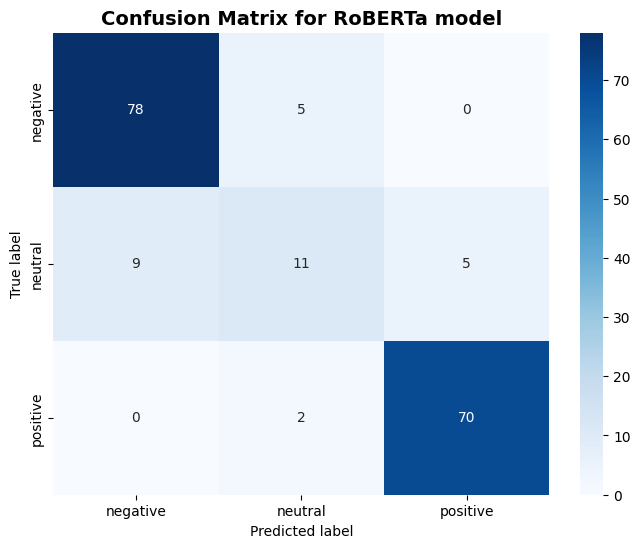

In [49]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: RoBERTa for Text polarity', fontsize=12, fontweight='bold')
plt.show()

### 4 DistilBERT

Tokenizing and Encoding the Data

In [22]:
# create tokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [24]:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [25]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=3)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [26]:
batch_size = 64
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Finetuning the model

In [27]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.929000,0.743144,0.740000,0.596232,0.740000,0.660253
2,0.559100,0.544827,0.755000,0.748107,0.755000,0.700186
3,0.386200,0.475625,0.820000,0.813763,0.820000,0.804070
4,0.325900,0.443782,0.825000,0.815212,0.825000,0.815271
5,0.299100,0.457621,0.830000,0.828059,0.830000,0.824265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
preds_output = trainer.predict(val_dataset)

In [29]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric       Value
0                test_loss    0.457621
1            test_accuracy    0.830000
2           test_precision    0.828059
3              test_recall    0.830000
4                  test_f1    0.824265
5             test_runtime    0.446200
6  test_samples_per_second  448.202000
7    test_steps_per_second    8.964000


Evaluation on test dataset

In [30]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [31]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.859     0.952     0.903        83
           1      0.533     0.320     0.400        25
           2      0.945     0.958     0.952        72

    accuracy                          0.867       180
   macro avg      0.779     0.743     0.752       180
weighted avg      0.848     0.867     0.853       180



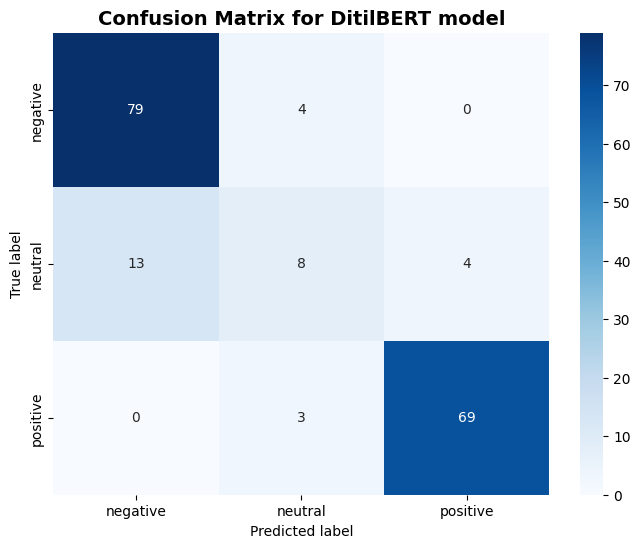

In [32]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: DitilBERT for Text polarity', fontsize=12, fontweight='bold')
plt.show()

### 5	XLNet

Tokenizing and Encoding the Data

In [57]:
# create tokenizer
model_ckpt = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_ckpt)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [58]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [59]:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [60]:
model = XLNetForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)
model.to(device)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [61]:
batch_size = 64
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Finetuning the model

In [62]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.925900,0.707758,0.710000,0.765444,0.710000,0.640373
2,0.541000,0.593213,0.750000,0.734255,0.750000,0.716707
3,0.371900,0.518965,0.820000,0.813592,0.820000,0.809265
4,0.302400,0.512252,0.820000,0.810990,0.820000,0.806318
5,0.279900,0.496356,0.840000,0.835933,0.840000,0.835895


In [63]:
preds_output = trainer.predict(val_dataset)

In [64]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric      Value
0                test_loss   0.496356
1            test_accuracy   0.840000
2           test_precision   0.835933
3              test_recall   0.840000
4                  test_f1   0.835895
5             test_runtime   2.045900
6  test_samples_per_second  97.756000
7    test_steps_per_second   1.955000


Evaluation on test dataset

In [65]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [66]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.857     0.940     0.897        83
           1      0.500     0.280     0.359        25
           2      0.933     0.972     0.952        72

    accuracy                          0.861       180
   macro avg      0.763     0.731     0.736       180
weighted avg      0.838     0.861     0.844       180



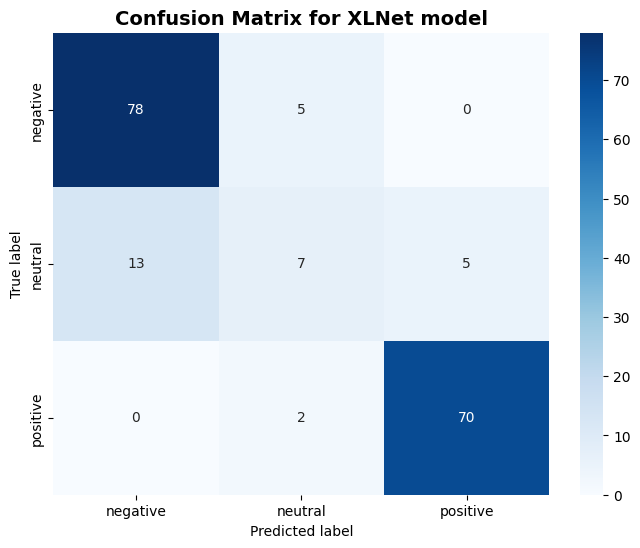

In [67]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: XLNet for Text polarity', fontsize=12, fontweight='bold')
plt.show()

### 6 ELECTRA

Tokenizing:

In [50]:
model_ckpt = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [51]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [52]:
# here 'label' are encoded sentiment values:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [53]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=3)
         .to(device))

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [54]:
batch_size = 64
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


Finetuning the model

In [55]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.974400,0.862446,0.745000,0.600318,0.745000,0.664826
2,0.664700,0.607093,0.755000,0.630909,0.755000,0.679586
3,0.471200,0.540722,0.760000,0.738365,0.760000,0.693270
4,0.387700,0.487820,0.790000,0.763929,0.790000,0.753115
5,0.352900,0.472925,0.820000,0.812597,0.820000,0.799821


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
preds_output = trainer.predict(val_dataset)

In [42]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric       Value
0                test_loss    0.442961
1            test_accuracy    0.865000
2           test_precision    0.859461
3              test_recall    0.865000
4                  test_f1    0.859161
5             test_runtime    0.921600
6  test_samples_per_second  217.019000
7    test_steps_per_second    7.596000


Evaluation on test dataset

In [43]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [44]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.924     0.880     0.901        83
           1      0.519     0.560     0.538        25
           2      0.932     0.958     0.945        72

    accuracy                          0.867       180
   macro avg      0.792     0.799     0.795       180
weighted avg      0.871     0.867     0.868       180



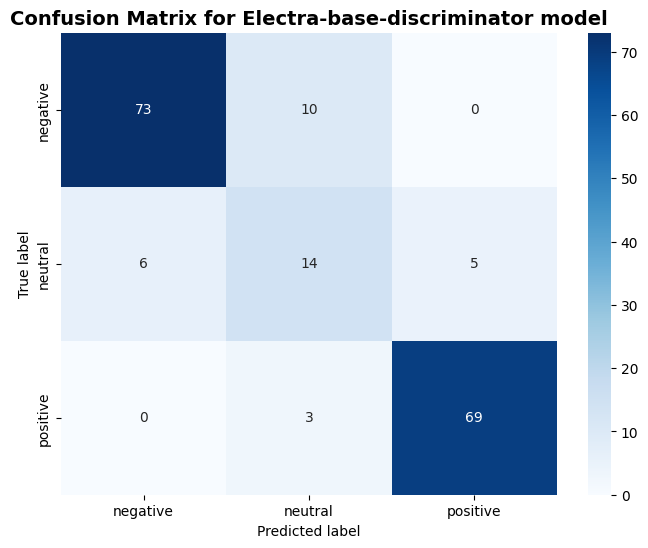

In [46]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: ELECTRA for Text polarity', fontsize=12, fontweight='bold')
plt.show()

### 7 DeBERTa

Tokenizing:

In [56]:
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [57]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [58]:
# here 'label' are encoded sentiment values:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [59]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=3)
         .to(device))

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [60]:
batch_size = 64
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


Finetuning the model

In [61]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.948300,0.697876,0.770000,0.621341,0.770000,0.687485
2,0.509300,0.560807,0.750000,0.642388,0.750000,0.679642
3,0.360400,0.449883,0.805000,0.791105,0.805000,0.775843
4,0.280000,0.393677,0.850000,0.843700,0.850000,0.835010
5,0.236800,0.388974,0.855000,0.849286,0.855000,0.841626


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
preds_output = trainer.predict(val_dataset)

In [58]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric       Value
0                test_loss    0.347821
1            test_accuracy    0.860000
2           test_precision    0.853442
3              test_recall    0.860000
4                  test_f1    0.855120
5             test_runtime    1.206100
6  test_samples_per_second  165.829000
7    test_steps_per_second    5.804000


Evaluation on test dataset

In [59]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [60]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.929     0.940     0.934        83
           1      0.700     0.560     0.622        25
           2      0.934     0.986     0.959        72

    accuracy                          0.906       180
   macro avg      0.854     0.829     0.839       180
weighted avg      0.899     0.906     0.901       180



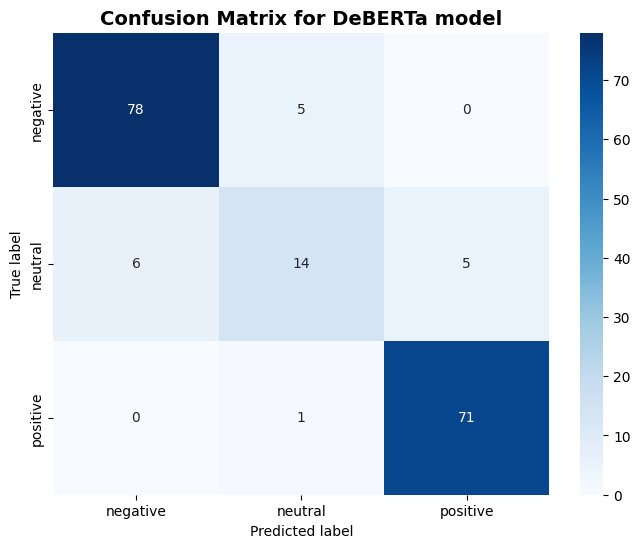

In [61]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: DeBERTa for Text polarity', fontsize=12, fontweight='bold')
plt.show()

Save model:

In [62]:
from huggingface_hub import notebook_login

notebook_login()

In [63]:
trainer.save_model("./my_model")

In [64]:
trainer.push_to_hub("your-username", model_name="DeBERTa-sentiment")

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

events.out.tfevents.1717540443.efbe47e7c3d6.417.6:   0%|          | 0.00/8.87k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Gregorig/deberta-v3-base-finetuned/commit/84e1ec92dde117accd5b96bd72733d8a6e01feb4', commit_message='your-username', commit_description='', oid='84e1ec92dde117accd5b96bd72733d8a6e01feb4', pr_url=None, pr_revision=None, pr_num=None)

### 8 XLM-RoBERTa

Tokenizing:

In [15]:
model_ckpt = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [16]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [17]:
# here 'label' are encoded sentiment values:
train_dataset = MyDataset(encoded_data_train, train_df['label'].values)
val_dataset = MyDataset(encoded_data_val, val_df['label'].values)
test_dataset = MyDataset(encoded_data_test, test_df['label'].values)

Loading a pretrained model

In [19]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=3)
         .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
batch_size = 64
logging_steps = len(train_dataset) // batch_size

model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


Finetuning the model

In [29]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.283700,0.507723,0.835000,0.829048,0.835000,0.829283
2,0.288800,0.523510,0.845000,0.849848,0.845000,0.836364
3,0.190300,0.597666,0.825000,0.821064,0.825000,0.816631
4,0.148100,0.577817,0.825000,0.817603,0.825000,0.816174
5,0.127900,0.507592,0.845000,0.839795,0.845000,0.841480


In [30]:
preds_output = trainer.predict(val_dataset)

In [31]:
metrics_finetun = preds_output.metrics
metrics_finetun_df = pd.DataFrame(list(metrics_finetun.items()), columns=['Metric', 'Value'])
print(metrics_finetun_df)

                    Metric       Value
0                test_loss    0.507592
1            test_accuracy    0.845000
2           test_precision    0.839795
3              test_recall    0.845000
4                  test_f1    0.841480
5             test_runtime    0.918900
6  test_samples_per_second  217.642000
7    test_steps_per_second    4.353000


Evaluation on test dataset

In [32]:
pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

In [33]:
print(classification_report(test_df["label"], pred, digits=3))

              precision    recall  f1-score   support

           0      0.925     0.892     0.908        83
           1      0.577     0.600     0.588        25
           2      0.919     0.944     0.932        72

    accuracy                          0.872       180
   macro avg      0.807     0.812     0.809       180
weighted avg      0.874     0.872     0.873       180



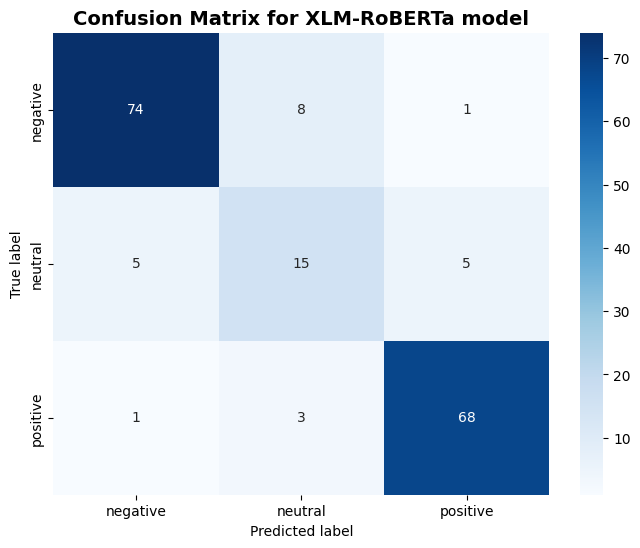

In [34]:
# confusion matrix
conf_matrix = confusion_matrix(test_df["label"], pred)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: XLM-RoBERTa for Text polarity', fontsize=12, fontweight='bold')
plt.show()

## Motives & Topics

In [18]:
# Define the column names
columns = ['t_communication', 't_payment' , 't_refund', 't_price', 't_value',
           't_shipping', 't_product', 't_feedback', 't_vendor', 't_generic',
           't_overall', 'm_help_other_buyer', 'm_avoid_harm_seler', 'm_help_seller',
           'm_rew_pun_seller', 'm_reach_seller', 'm_express_emo', 'm_share_facts']


In [19]:
# Function to calculate class weights
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
    return torch.tensor(class_weights, dtype=torch.float)

In [26]:
# Custom Trainer class to handle weighted loss
class WeightedTrainer(Trainer):
    def __init__(self, *args, weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = weight

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### 1 Baseline

In [ ]:
# Initialize metrics dataframe for Baseline
baseline_metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                            'F1-Score_0', 'F1-Score_1'])

# Random seed for reproducibility
random.seed(12345)

# Iterate through each column
for column in columns:
    print(f"Generating baseline predictions for category: {column}")

    # Get true labels
    true_labels = test_df[column].values
    labels = np.unique(true_labels)

    # Generate random predictions
    baseline_pred = [random.choice(labels) for _ in range(len(test_df))]

    # Calculate metrics
    report = classification_report(true_labels, baseline_pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    baseline_metrics_df = pd.concat([baseline_metrics_df, metrics_row], ignore_index=True)

# Calculate average metrics for the Baseline model
avg_accuracy_all = baseline_metrics_df['Accuracy'].mean()
avg_f1_score_all = baseline_metrics_df['F1-Score'].mean()

avg_accuracy_t = baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()

avg_accuracy_m = baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()

# Append average metrics to the DataFrame for the Baseline model
avg_baseline_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': baseline_metrics_df['F1-Score_0'].mean(),
    'F1-Score_1': baseline_metrics_df['F1-Score_1'].mean()
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean(),
    'F1-Score_1': baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean(),
    'F1-Score_1': baseline_metrics_df[baseline_metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()
}])

baseline_metrics_df = pd.concat([baseline_metrics_df, avg_baseline_metrics_row], ignore_index=True)


### 2 BERT

In [27]:
# Load tokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Encode the data
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [28]:
# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                   'F1-Score_0', 'F1-Score_1'])


# Create directory to save confusion matrices if it doesn't exist
conf_matrix_dir = join(PROJECT_DIR, "Results/Confusion_matrix/BERT")
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

In [29]:
# Iterate through each column
for column in columns:
    print(f"Training on category: {column}")

    # Create datasets for the current category
    train_dataset = MyDataset(encoded_data_train, train_df[column].values)
    val_dataset = MyDataset(encoded_data_val, val_df[column].values)
    test_dataset = MyDataset(encoded_data_test, test_df[column].values)

    # Calculate class weights
    class_weights = calculate_class_weights(train_df[column].values)
    class_weights = class_weights.to(device)

    # Load model
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=2)
             .to(device))

    # Define training arguments
    batch_size = 32
    logging_steps = len(train_dataset) // batch_size

    model_name = f"{model_ckpt}-finetuned-{column}"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    # Initialize Trainer with custom weighted loss
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        weight=class_weights
    )

    # Train the model
    trainer.train()

    # Evaluate on validation dataset
    preds_output = trainer.predict(val_dataset)
    metrics = preds_output.metrics

    # Predict on test dataset
    pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    report = classification_report(test_df[column], pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)


    conf_matrix = confusion_matrix(test_df[column], pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix: BERT for {column}', fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(conf_matrix_dir, f'confusion_matrix_{column}.png'))
    plt.close()

Training on category: t_communication


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.540400,0.305396,0.845000,0.911903,0.845000,0.860235
2,0.263800,0.217702,0.945000,0.945681,0.945000,0.945304
3,0.146200,0.201972,0.950000,0.951376,0.950000,0.950542


Training on category: t_payment


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.643700,0.549284,0.885000,0.940286,0.885000,0.907280
2,0.335600,0.279610,0.980000,0.980000,0.980000,0.980000
3,0.224700,0.218450,0.980000,0.980000,0.980000,0.980000


Training on category: t_refund


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.511200,0.481913,0.950000,0.955243,0.950000,0.952368
2,0.228100,0.318895,0.940000,0.968671,0.940000,0.949908
3,0.107300,0.418694,0.975000,0.973828,0.975000,0.974297


Training on category: t_price


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.632400,0.456602,0.920000,0.975351,0.920000,0.945410
2,0.454000,0.345507,0.990000,0.990101,0.990000,0.987525
3,0.248700,0.311592,0.990000,0.990101,0.990000,0.987525


Training on category: t_value


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.631600,0.429525,0.950000,0.965676,0.950000,0.955851
2,0.324300,0.216477,0.980000,0.980000,0.980000,0.980000
3,0.191900,0.210692,0.980000,0.980000,0.980000,0.980000


Training on category: t_shipping


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.576000,0.464188,0.795000,0.805418,0.795000,0.794389
2,0.306800,0.300669,0.870000,0.870954,0.870000,0.869686
3,0.169300,0.294516,0.890000,0.891087,0.890000,0.889734


Training on category: t_product


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.614900,0.537446,0.745000,0.744673,0.745000,0.739088
2,0.397000,0.412216,0.830000,0.830726,0.830000,0.830279
3,0.278900,0.409982,0.830000,0.830726,0.830000,0.830279


Training on category: t_feedback


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.469000,0.133206,1.000000,1.000000,1.000000,1.000000
2,0.319100,0.053502,0.995000,0.996667,0.995000,0.995494
3,0.114300,0.025737,1.000000,1.000000,1.000000,1.000000


Training on category: t_vendor


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.614000,0.460541,0.805000,0.903598,0.805000,0.830578
2,0.359200,0.365065,0.860000,0.896014,0.860000,0.871700
3,0.236500,0.365287,0.850000,0.892428,0.850000,0.863596


Training on category: t_generic


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.418300,0.343318,0.965000,0.966458,0.965000,0.965653
2,0.136400,0.416473,0.965000,0.966458,0.965000,0.965653
3,0.042100,0.457263,0.975000,0.974170,0.975000,0.974490


Training on category: t_overall


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.604400,0.523477,0.905000,0.913971,0.905000,0.908630
2,0.439200,0.498218,0.905000,0.903409,0.905000,0.904166
3,0.338400,0.493388,0.910000,0.907087,0.910000,0.908381


Training on category: m_help_other_buyer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.559200,0.423853,0.905000,0.909130,0.905000,0.906767
2,0.355100,0.285773,0.890000,0.916194,0.890000,0.897755
3,0.228100,0.279571,0.940000,0.938685,0.940000,0.939176


Training on category: m_avoid_harm_seler


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.613300,0.475176,0.755000,0.962279,0.755000,0.832401
2,0.467800,0.352083,0.890000,0.960971,0.890000,0.918247
3,0.350800,0.354707,0.905000,0.955917,0.905000,0.926215


Training on category: m_help_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685800,0.571926,0.875000,0.942990,0.875000,0.900656
2,0.488400,0.445201,0.950000,0.950000,0.950000,0.950000
3,0.317600,0.532844,0.955000,0.949844,0.955000,0.951625


Training on category: m_rew_pun_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.576500,0.554924,0.840000,0.858677,0.840000,0.847781
2,0.391900,0.534357,0.865000,0.870960,0.865000,0.867722
3,0.289500,0.602811,0.875000,0.866714,0.875000,0.870004


Training on category: m_reach_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.522600,0.382860,0.845000,0.984465,0.845000,0.906982
2,0.303200,0.300115,0.975000,0.979949,0.975000,0.977468
3,0.158400,0.349037,0.970000,0.979898,0.970000,0.974924


Training on category: m_express_emo


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.629300,0.549261,0.695000,0.799037,0.695000,0.712887
2,0.524300,0.526949,0.765000,0.786299,0.765000,0.772400
3,0.448400,0.547343,0.765000,0.766435,0.765000,0.765697


Training on category: m_share_facts


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.559200,0.444908,0.740000,0.817951,0.740000,0.749673
2,0.394400,0.388230,0.850000,0.857473,0.850000,0.852307
3,0.300700,0.363806,0.840000,0.850286,0.840000,0.842963


In [ ]:
# Calculate average metrics for the current model
avg_accuracy_all = metrics_df['Accuracy'].mean()
avg_f1_score_all = metrics_df['F1-Score'].mean()
avg_f1_score_0_all = metrics_df['F1-Score_0'].mean()
avg_f1_score_1_all = metrics_df['F1-Score_1'].mean()

avg_accuracy_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()
avg_f1_score_0_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean()
avg_f1_score_1_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()

avg_accuracy_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()
avg_f1_score_0_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean()
avg_f1_score_1_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()


# Append average metrics to the DataFrame for the current model
avg_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': avg_f1_score_0_all,
    'F1-Score_1': avg_f1_score_1_all
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': avg_f1_score_0_t,
    'F1-Score_1': avg_f1_score_1_t
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': avg_f1_score_0_m,
    'F1-Score_1': avg_f1_score_1_m
}])

metrics_df = pd.concat([metrics_df, avg_metrics_row], ignore_index=True)


In [ ]:
metrics_df

,Category,Accuracy,F1-Score,F1-Score_0,F1-Score_1
0,t_communication,0.961111,0.961963,0.97491,0.91358
1,t_payment,0.972222,0.973445,0.985673,0.545455
2,t_refund,0.988889,0.988889,0.994048,0.916667
3,t_price,0.988889,0.989783,0.994253,0.833333
4,t_value,0.988889,0.988889,0.994118,0.9
5,t_shipping,0.933333,0.933333,0.924051,0.940594
6,t_product,0.888889,0.889195,0.90099,0.873418
7,t_feedback,0.977778,0.977778,0.988636,0.5
8,t_vendor,0.938889,0.939902,0.962199,0.84058
9,t_generic,0.972222,0.975035,0.985163,0.782609


In [30]:
metrics_df.to_csv(join(PROJECT_DIR, "Results/metrics/BERT.csv"))

### 3 RoBERTa

In [31]:
# Load tokenizer
model_ckpt = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(model_ckpt)

# Encode the data
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [90]:
# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                   'F1-Score_0', 'F1-Score_1'])


# Create directory to save confusion matrices if it doesn't exist
conf_matrix_dir = join(PROJECT_DIR, "Results/Confusion_matrix/RoBERTa")
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

In [91]:
# Iterate through each column
for column in columns:
    print(f"Training on category: {column}")

    # Create datasets for the current category
    train_dataset = MyDataset(encoded_data_train, train_df[column].values)
    val_dataset = MyDataset(encoded_data_val, val_df[column].values)
    test_dataset = MyDataset(encoded_data_test, test_df[column].values)

    # Calculate class weights
    class_weights = calculate_class_weights(train_df[column].values)
    class_weights = class_weights.to(device)

    # Load model
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=2)
             .to(device))

    # Define training arguments
    batch_size = 32
    logging_steps = len(train_dataset) // batch_size

    model_name = f"{model_ckpt}-finetuned-{column}"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    # Initialize Trainer with custom weighted loss
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        weight=class_weights
    )

    # Train the model
    trainer.train()

    # Evaluate on validation dataset
    preds_output = trainer.predict(val_dataset)
    metrics = preds_output.metrics

    # Predict on test dataset
    pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    report = classification_report(test_df[column], pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)

    conf_matrix = confusion_matrix(test_df[column], pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix: RoBERTa for {column}', fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(conf_matrix_dir, f'confusion_matrix_{column}.png'))
    plt.close()

Training on category: t_communication


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.368000,0.111033,0.950000,0.958117,0.950000,0.951943
2,0.167700,0.097174,0.945000,0.952057,0.945000,0.946904
3,0.078100,0.081921,0.975000,0.974796,0.975000,0.974857


Training on category: t_payment


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.222100,0.212223,0.950000,0.902500,0.950000,0.925641
2,0.158500,0.192494,0.950000,0.902500,0.950000,0.925641
3,0.152700,0.192343,0.950000,0.902500,0.950000,0.925641


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Training on category: t_refund


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.210500,0.156425,0.960000,0.961608,0.960000,0.944410
2,0.087200,0.090398,0.980000,0.980000,0.980000,0.980000


KeyboardInterrupt: 

In [ ]:
# Calculate average metrics for the current model
avg_accuracy_all = metrics_df['Accuracy'].mean()
avg_f1_score_all = metrics_df['F1-Score'].mean()
avg_f1_score_0_all = metrics_df['F1-Score_0'].mean()
avg_f1_score_1_all = metrics_df['F1-Score_1'].mean()

avg_accuracy_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()
avg_f1_score_0_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean()
avg_f1_score_1_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()

avg_accuracy_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()
avg_f1_score_0_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean()
avg_f1_score_1_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()


# Append average metrics to the DataFrame for the current model
avg_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': avg_f1_score_0_all,
    'F1-Score_1': avg_f1_score_1_all
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': avg_f1_score_0_t,
    'F1-Score_1': avg_f1_score_1_t
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': avg_f1_score_0_m,
    'F1-Score_1': avg_f1_score_1_m
}])

metrics_df = pd.concat([metrics_df, avg_metrics_row], ignore_index=True)


In [ ]:
metrics_df

,Category,Accuracy,F1-Score,F1-Score_0,F1-Score_1
0,t_communication,0.961111,0.961963,0.97491,0.91358
1,t_payment,0.972222,0.973445,0.985673,0.545455
2,t_refund,0.988889,0.988889,0.994048,0.916667
3,t_price,0.988889,0.989783,0.994253,0.833333
4,t_value,0.988889,0.988889,0.994118,0.9
5,t_shipping,0.933333,0.933333,0.924051,0.940594
6,t_product,0.888889,0.889195,0.90099,0.873418
7,t_feedback,0.977778,0.977778,0.988636,0.5
8,t_vendor,0.938889,0.939902,0.962199,0.84058
9,t_generic,0.972222,0.975035,0.985163,0.782609


In [ ]:
metrics_df.to_csv(join(PROJECT_DIR, "Results/metrics/RoBERTa.csv"))

### 4 DistilBERT

In [33]:
# Load tokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Encode the data
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [34]:
# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                   'F1-Score_0', 'F1-Score_1'])

# Create directory to save confusion matrices if it doesn't exist
conf_matrix_dir = join(PROJECT_DIR, "Results/Confusion_matrix/DistilBERT")
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

In [37]:
# Iterate through each column
for column in columns:
    print(f"Training on category: {column}")

    # Create datasets for the current category
    train_dataset = MyDataset(encoded_data_train, train_df[column].values)
    val_dataset = MyDataset(encoded_data_val, val_df[column].values)
    test_dataset = MyDataset(encoded_data_test, test_df[column].values)

    # Calculate class weights
    class_weights = calculate_class_weights(train_df[column].values)
    class_weights = class_weights.to(device)

    # Load model
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=2)
             .to(device))

    # Define training arguments
    batch_size = 64
    logging_steps = len(train_dataset) // batch_size

    model_name = f"{model_ckpt}-finetuned-{column}"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    # Initialize Trainer with custom weighted loss
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        weight=class_weights
    )

    # Train the model
    trainer.train()

    # Evaluate on validation dataset
    preds_output = trainer.predict(val_dataset)
    metrics = preds_output.metrics

    # Predict on test dataset
    pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    report = classification_report(test_df[column], pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)

    conf_matrix = confusion_matrix(test_df[column], pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix: DistilBERT for {column}', fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(conf_matrix_dir, f'confusion_matrix_{column}.png'))
    plt.close()

Training on category: t_communication


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.612100,0.448642,0.820000,0.892821,0.820000,0.838000
2,0.355100,0.206891,0.930000,0.946204,0.930000,0.933801
3,0.197300,0.154296,0.950000,0.958117,0.950000,0.951943
4,0.136200,0.142547,0.965000,0.966788,0.965000,0.965559
5,0.103900,0.138908,0.960000,0.962828,0.960000,0.960836


Training on category: t_payment


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.672100,0.647233,0.595000,0.946498,0.595000,0.703443
2,0.566600,0.451471,0.880000,0.952157,0.880000,0.906667
3,0.397600,0.289916,0.980000,0.980000,0.980000,0.980000
4,0.243400,0.251496,0.990000,0.990104,0.990000,0.989471
5,0.184700,0.217142,0.990000,0.990104,0.990000,0.989471


Training on category: t_refund


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.621900,0.584586,0.880000,0.935849,0.880000,0.903967
2,0.402500,0.370866,0.945000,0.958882,0.945000,0.950614
3,0.193900,0.401018,0.975000,0.973828,0.975000,0.974297
4,0.151000,0.379741,0.965000,0.971090,0.965000,0.967361
5,0.111700,0.430315,0.980000,0.980000,0.980000,0.980000


Training on category: t_price


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.651700,0.644016,0.570000,0.985506,0.570000,0.710946
2,0.491700,0.366360,0.975000,0.984923,0.975000,0.979071
3,0.257100,0.180008,0.980000,0.985949,0.980000,0.982449
4,0.149600,0.293247,0.995000,0.995025,0.995000,0.994506
5,0.107600,0.235394,0.995000,0.995025,0.995000,0.994506


Training on category: t_value


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676100,0.622889,0.715000,0.961136,0.715000,0.798308
2,0.525600,0.418326,0.945000,0.964307,0.945000,0.952187
3,0.381300,0.305885,0.975000,0.979920,0.975000,0.976687
4,0.261900,0.227272,0.950000,0.970958,0.950000,0.957158
5,0.182900,0.194941,0.965000,0.975580,0.965000,0.968572


Training on category: t_shipping


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.614600,0.535270,0.770000,0.781004,0.770000,0.769171
2,0.432800,0.354495,0.890000,0.892939,0.890000,0.890044
3,0.234700,0.253536,0.930000,0.930242,0.930000,0.930028
4,0.168000,0.245933,0.930000,0.930828,0.930000,0.930042
5,0.131200,0.241301,0.910000,0.910480,0.910000,0.909873


Training on category: t_product


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.639500,0.578868,0.700000,0.701125,0.700000,0.700493
2,0.486500,0.489980,0.795000,0.793945,0.795000,0.793465
3,0.363000,0.469380,0.790000,0.788933,0.790000,0.788155
4,0.284000,0.462426,0.800000,0.799079,0.800000,0.799212
5,0.237200,0.461734,0.815000,0.815355,0.815000,0.815157


Training on category: t_feedback


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.602500,0.509021,0.890000,0.990833,0.890000,0.933303
2,0.406400,0.294631,0.965000,0.992222,0.965000,0.975821
3,0.223600,0.076252,1.000000,1.000000,1.000000,1.000000
4,0.118200,0.045158,0.995000,0.996667,0.995000,0.995494
5,0.114300,0.030835,1.000000,1.000000,1.000000,1.000000


Training on category: t_vendor


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.643100,0.564355,0.715000,0.895963,0.715000,0.757050
2,0.482300,0.465089,0.870000,0.899883,0.870000,0.879864
3,0.357700,0.391792,0.860000,0.922922,0.860000,0.875907
4,0.280100,0.352698,0.890000,0.917519,0.890000,0.898347
5,0.220300,0.333033,0.885000,0.920301,0.885000,0.895026


Training on category: t_generic


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.543400,0.336629,0.925000,0.961029,0.925000,0.936833
2,0.208900,0.236309,0.965000,0.966458,0.965000,0.965653
3,0.096200,0.369640,0.970000,0.970000,0.970000,0.970000
4,0.084600,0.206523,0.980000,0.980000,0.980000,0.980000
5,0.070000,0.206873,0.980000,0.980000,0.980000,0.980000


Training on category: t_overall


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.645800,0.516102,0.800000,0.884097,0.800000,0.827202
2,0.472500,0.408121,0.835000,0.916254,0.835000,0.857832
3,0.389900,0.408565,0.885000,0.904279,0.885000,0.892254
4,0.329600,0.399830,0.885000,0.904279,0.885000,0.892254
5,0.263800,0.388544,0.890000,0.915727,0.890000,0.898692


Training on category: m_help_other_buyer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.635100,0.529528,0.825000,0.882033,0.825000,0.842288
2,0.508200,0.428796,0.845000,0.893953,0.845000,0.859474
3,0.402700,0.342893,0.895000,0.922887,0.895000,0.902789
4,0.330800,0.303335,0.935000,0.940640,0.935000,0.936937
5,0.270900,0.283395,0.930000,0.937372,0.930000,0.932456


Training on category: m_avoid_harm_seler


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.633200,0.664633,0.520000,0.967379,0.520000,0.650006
2,0.569900,0.540250,0.730000,0.969016,0.730000,0.815248
3,0.438400,0.439551,0.780000,0.969804,0.780000,0.849296
4,0.330100,0.323750,0.860000,0.965585,0.860000,0.900444
5,0.294900,0.324562,0.865000,0.965818,0.865000,0.903595


Training on category: m_help_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.675400,0.621322,0.870000,0.923600,0.870000,0.892778
2,0.548400,0.456745,0.855000,0.953640,0.855000,0.889372
3,0.410200,0.457426,0.920000,0.938592,0.920000,0.927926
4,0.289400,0.428017,0.925000,0.945620,0.925000,0.933344
5,0.209900,0.508485,0.930000,0.941459,0.930000,0.935010


Training on category: m_rew_pun_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.617500,0.528312,0.875000,0.876814,0.875000,0.875876
2,0.430900,0.506880,0.840000,0.858677,0.840000,0.847781
3,0.315000,0.535235,0.860000,0.872571,0.860000,0.865313
4,0.273200,0.561020,0.850000,0.867841,0.850000,0.857295
5,0.246900,0.596328,0.880000,0.873600,0.880000,0.876249


Training on category: m_reach_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.630600,0.655663,0.610000,0.990250,0.610000,0.747658
2,0.469600,0.438806,0.865000,0.990690,0.865000,0.918851
3,0.284100,0.308560,0.945000,0.985671,0.945000,0.963399
4,0.192500,0.237346,0.930000,0.985392,0.930000,0.955156
5,0.130600,0.275748,0.945000,0.985671,0.945000,0.963399


Training on category: m_express_emo


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.653200,0.599309,0.705000,0.779716,0.705000,0.721681
2,0.589700,0.543308,0.750000,0.799639,0.750000,0.762494
3,0.531000,0.501704,0.785000,0.801733,0.785000,0.790928
4,0.472700,0.483743,0.800000,0.811133,0.800000,0.804220
5,0.448500,0.481194,0.815000,0.818586,0.815000,0.816592


Training on category: m_share_facts


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.601500,0.514403,0.780000,0.830604,0.780000,0.788014
2,0.474500,0.426752,0.855000,0.863554,0.855000,0.857462
3,0.376200,0.396402,0.860000,0.863057,0.860000,0.861158
4,0.322600,0.360254,0.870000,0.876945,0.870000,0.871999
5,0.264700,0.345633,0.870000,0.876945,0.870000,0.871999


In [ ]:
# Calculate average metrics for the current model
avg_accuracy_all = metrics_df['Accuracy'].mean()
avg_f1_score_all = metrics_df['F1-Score'].mean()
avg_f1_score_0_all = metrics_df['F1-Score_0'].mean()
avg_f1_score_1_all = metrics_df['F1-Score_1'].mean()

avg_accuracy_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()
avg_f1_score_0_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean()
avg_f1_score_1_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()

avg_accuracy_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()
avg_f1_score_0_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean()
avg_f1_score_1_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()


# Append average metrics to the DataFrame for the current model
avg_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': avg_f1_score_0_all,
    'F1-Score_1': avg_f1_score_1_all
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': avg_f1_score_0_t,
    'F1-Score_1': avg_f1_score_1_t
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': avg_f1_score_0_m,
    'F1-Score_1': avg_f1_score_1_m
}])

metrics_df = pd.concat([metrics_df, avg_metrics_row], ignore_index=True)


In [ ]:
metrics_df

,Category,Accuracy,F1-Score,F1-Score_0,F1-Score_1
0,t_communication,0.961111,0.961963,0.97491,0.91358
1,t_payment,0.972222,0.973445,0.985673,0.545455
2,t_refund,0.988889,0.988889,0.994048,0.916667
3,t_price,0.988889,0.989783,0.994253,0.833333
4,t_value,0.988889,0.988889,0.994118,0.9
5,t_shipping,0.933333,0.933333,0.924051,0.940594
6,t_product,0.888889,0.889195,0.90099,0.873418
7,t_feedback,0.977778,0.977778,0.988636,0.5
8,t_vendor,0.938889,0.939902,0.962199,0.84058
9,t_generic,0.972222,0.975035,0.985163,0.782609


In [38]:
metrics_df.to_csv(join(PROJECT_DIR, "Results/metrics/DistilBERT.csv"))

### 5 DeBERTa

In [39]:
# Load tokenizer
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Encode the data
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [40]:
# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                   'F1-Score_0', 'F1-Score_1'])

# Create directory to save confusion matrices if it doesn't exist
conf_matrix_dir = join(PROJECT_DIR, "Results/Confusion_matrix/DeBERTa")
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

In [41]:
# Iterate through each column
for column in columns:
    print(f"Training on category: {column}")

    # Create datasets for the current category
    train_dataset = MyDataset(encoded_data_train, train_df[column].values)
    val_dataset = MyDataset(encoded_data_val, val_df[column].values)
    test_dataset = MyDataset(encoded_data_test, test_df[column].values)

    # Calculate class weights
    class_weights = calculate_class_weights(train_df[column].values)
    class_weights = class_weights.to(device)

    # Load model
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=2)
             .to(device))

    # Define training arguments
    batch_size = 64
    logging_steps = len(train_dataset) // batch_size

    model_name = f"{model_ckpt}-finetuned-{column}"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    # Initialize Trainer with custom weighted loss
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        weight=class_weights
    )

    # Train the model
    trainer.train()

    # Evaluate on validation dataset
    preds_output = trainer.predict(val_dataset)
    metrics = preds_output.metrics

    # Predict on test dataset
    pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    report = classification_report(test_df[column], pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)

    conf_matrix = confusion_matrix(test_df[column], pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix: DeBERTa for {column}', fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(conf_matrix_dir, f'confusion_matrix_{column}.png'))
    plt.close()

Training on category: t_communication


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.640700,0.430556,0.760000,0.884465,0.760000,0.787854
2,0.342600,0.162742,0.940000,0.948793,0.940000,0.942332
3,0.164200,0.185090,0.935000,0.945673,0.935000,0.937791
4,0.120900,0.166120,0.955000,0.957091,0.955000,0.955718
5,0.087000,0.169694,0.950000,0.955476,0.950000,0.951511


Training on category: t_payment


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.686200,0.701591,0.950000,0.902500,0.950000,0.925641
2,0.635500,0.650540,0.955000,0.957035,0.955000,0.937111
3,0.527300,0.568877,0.945000,0.957928,0.945000,0.950133
4,0.288800,0.582532,0.985000,0.985233,0.985000,0.983735
5,0.151800,0.530013,0.985000,0.985233,0.985000,0.983735


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: t_refund


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.672900,0.629394,0.955000,0.912025,0.955000,0.933018
2,0.406100,0.338393,0.960000,0.973838,0.960000,0.964681
3,0.292200,0.365225,0.955000,0.972310,0.955000,0.960880
4,0.082000,0.416793,0.970000,0.977585,0.970000,0.972569
5,0.060700,0.523493,0.970000,0.973531,0.970000,0.971421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: t_price


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692000,0.649619,0.985000,0.970225,0.985000,0.977557
2,0.625800,0.506727,0.780000,0.985957,0.780000,0.862971
3,0.345000,0.158352,0.995000,0.995025,0.995000,0.994506
4,0.189300,0.044630,1.000000,1.000000,1.000000,1.000000
5,0.077000,0.018640,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: t_value


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.698000,0.676143,0.515000,0.958821,0.515000,0.637008
2,0.629700,0.497958,0.880000,0.967273,0.880000,0.910263
3,0.432000,0.360799,0.975000,0.983929,0.975000,0.977552
4,0.308700,0.307636,0.965000,0.980313,0.965000,0.969573
5,0.249700,0.271561,0.980000,0.982674,0.980000,0.980947


Training on category: t_shipping


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.664900,0.576766,0.690000,0.752834,0.690000,0.675335
2,0.402000,0.291050,0.915000,0.920509,0.915000,0.914977
3,0.158600,0.205651,0.935000,0.935489,0.935000,0.935034
4,0.129300,0.229666,0.935000,0.938822,0.935000,0.935015
5,0.082600,0.209514,0.945000,0.947374,0.945000,0.945029


Training on category: t_product


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676700,0.631463,0.690000,0.754688,0.690000,0.686581
2,0.523100,0.501509,0.815000,0.814302,0.815000,0.813614
3,0.397600,0.459998,0.860000,0.866009,0.860000,0.860852
4,0.309900,0.417917,0.860000,0.860427,0.860000,0.858770
5,0.265300,0.413404,0.880000,0.880000,0.880000,0.880000


Training on category: t_feedback


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.660300,0.533757,0.990000,0.980100,0.990000,0.985025
2,0.434100,0.354958,0.975000,0.986923,0.975000,0.980262
3,0.244800,0.302176,0.995000,0.995025,0.995000,0.994173
4,0.180300,0.066106,0.980000,0.993333,0.980000,0.984898
5,0.096600,0.036360,0.990000,0.995000,0.990000,0.991641


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: t_vendor


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682100,0.642092,0.555000,0.869458,0.555000,0.613666
2,0.527200,0.366013,0.830000,0.915406,0.830000,0.851448
3,0.267400,0.288295,0.890000,0.927121,0.890000,0.899971
4,0.210800,0.347393,0.900000,0.913663,0.900000,0.904863
5,0.166500,0.317014,0.900000,0.921905,0.900000,0.906753


Training on category: t_generic


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.628000,0.426060,0.905000,0.957262,0.905000,0.922446
2,0.340400,0.252426,0.990000,0.990000,0.990000,0.990000
3,0.203000,0.232734,0.980000,0.980000,0.980000,0.980000
4,0.153700,0.205496,0.985000,0.984598,0.985000,0.984694
5,0.100300,0.207121,0.990000,0.990105,0.990000,0.989572


Training on category: t_overall


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.680600,0.611814,0.865000,0.886384,0.865000,0.873515
2,0.503200,0.403902,0.865000,0.906834,0.865000,0.878681
3,0.363100,0.430755,0.905000,0.917969,0.905000,0.909864
4,0.281100,0.438626,0.905000,0.917969,0.905000,0.909864
5,0.211700,0.458258,0.915000,0.923284,0.915000,0.918248


Training on category: m_help_other_buyer


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.661400,0.518715,0.785000,0.870761,0.785000,0.809978
2,0.440200,0.227708,0.950000,0.951579,0.950000,0.950632
3,0.243300,0.182441,0.945000,0.955969,0.945000,0.947734
4,0.168600,0.169380,0.965000,0.967025,0.965000,0.965651
5,0.156100,0.174720,0.955000,0.957376,0.955000,0.955837


Training on category: m_avoid_harm_seler


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679800,0.611929,0.945000,0.930536,0.945000,0.937712
2,0.541100,0.466483,0.780000,0.949434,0.780000,0.848373
3,0.434800,0.473196,0.710000,0.968769,0.710000,0.801165
4,0.290800,0.395187,0.855000,0.946308,0.855000,0.894329
5,0.234100,0.528417,0.880000,0.947757,0.880000,0.909405


Training on category: m_help_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688900,0.658149,0.945000,0.924773,0.945000,0.926601
2,0.581600,0.388678,0.925000,0.962547,0.925000,0.937593
3,0.402700,0.234522,0.950000,0.968726,0.950000,0.956126
4,0.269800,0.201080,0.965000,0.974239,0.965000,0.968006
5,0.196800,0.210229,0.965000,0.974239,0.965000,0.968006


Training on category: m_rew_pun_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.661500,0.568845,0.780000,0.854658,0.780000,0.804997
2,0.475100,0.507411,0.875000,0.880580,0.875000,0.877521
3,0.382600,0.520215,0.895000,0.888513,0.895000,0.890804
4,0.336700,0.535751,0.860000,0.868260,0.860000,0.863688
5,0.278000,0.536818,0.875000,0.873235,0.875000,0.874086


Training on category: m_reach_seller


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.665600,0.530229,0.990000,0.980100,0.990000,0.985025
2,0.535900,0.386099,0.755000,0.990392,0.755000,0.850956
3,0.338200,0.299010,0.970000,0.986564,0.970000,0.977347
4,0.266800,0.364569,0.930000,0.985392,0.930000,0.955156
5,0.177600,0.365909,0.955000,0.985928,0.955000,0.968913


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: m_express_emo


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.686200,0.649408,0.535000,0.781675,0.535000,0.543911
2,0.610100,0.519196,0.795000,0.807928,0.795000,0.799785
3,0.509500,0.484914,0.770000,0.809307,0.770000,0.780464
4,0.418500,0.478317,0.815000,0.833800,0.815000,0.820826
5,0.387100,0.485052,0.810000,0.823938,0.810000,0.814845


Training on category: m_share_facts


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.653900,0.492736,0.810000,0.818527,0.810000,0.812922
2,0.406300,0.325943,0.865000,0.870951,0.865000,0.866850
3,0.289800,0.305216,0.875000,0.878717,0.875000,0.876269
4,0.248600,0.321948,0.890000,0.890000,0.890000,0.890000
5,0.200000,0.314399,0.865000,0.868902,0.865000,0.866371


In [46]:
# Calculate average metrics for the current model
avg_accuracy_all = metrics_df['Accuracy'].mean()
avg_f1_score_all = metrics_df['F1-Score'].mean()
avg_f1_score_0_all = metrics_df['F1-Score_0'].mean()
avg_f1_score_1_all = metrics_df['F1-Score_1'].mean()

avg_accuracy_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()
avg_f1_score_0_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean()
avg_f1_score_1_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()

avg_accuracy_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()
avg_f1_score_0_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean()
avg_f1_score_1_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()


# Append average metrics to the DataFrame for the current model
avg_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': avg_f1_score_0_all,
    'F1-Score_1': avg_f1_score_1_all
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': avg_f1_score_0_t,
    'F1-Score_1': avg_f1_score_1_t
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': avg_f1_score_0_m,
    'F1-Score_1': avg_f1_score_1_m
}])

metrics_df = pd.concat([metrics_df, avg_metrics_row], ignore_index=True)


In [50]:
metrics_df

,Category,Accuracy,F1-Score,F1-Score_0,F1-Score_1
0,t_communication,0.961111,0.961963,0.97491,0.91358
1,t_payment,0.972222,0.973445,0.985673,0.545455
2,t_refund,0.988889,0.988889,0.994048,0.916667
3,t_price,0.988889,0.989783,0.994253,0.833333
4,t_value,0.988889,0.988889,0.994118,0.9
5,t_shipping,0.933333,0.933333,0.924051,0.940594
6,t_product,0.888889,0.889195,0.90099,0.873418
7,t_feedback,0.977778,0.977778,0.988636,0.5
8,t_vendor,0.938889,0.939902,0.962199,0.84058
9,t_generic,0.972222,0.975035,0.985163,0.782609


In [51]:
metrics_df.to_csv(join(PROJECT_DIR, "Results/metrics/DeBERTa.csv"))

### 6 XLM-RoBERTa

In [52]:
# Load tokenizer
model_ckpt = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Encode the data
encoded_data_train = tokenizer.batch_encode_plus(
    train_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_df["comment"].values.tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [53]:
# Initialize metrics dataframe
metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'F1-Score',
                                   'F1-Score_0', 'F1-Score_1'])

# Create directory to save confusion matrices if it doesn't exist
conf_matrix_dir = join(PROJECT_DIR, "Results/Confusion_matrix/XLM-RoBERTa")
if not os.path.exists(conf_matrix_dir):
    os.makedirs(conf_matrix_dir)

In [ ]:
# Iterate through each column
for column in columns:
    print(f"Training on category: {column}")

    # Create datasets for the current category
    train_dataset = MyDataset(encoded_data_train, train_df[column].values)
    val_dataset = MyDataset(encoded_data_val, val_df[column].values)
    test_dataset = MyDataset(encoded_data_test, test_df[column].values)

    # Calculate class weights
    class_weights = calculate_class_weights(train_df[column].values)
    class_weights = class_weights.to(device)

    # Load model
    model = (AutoModelForSequenceClassification
             .from_pretrained(model_ckpt, num_labels=2)
             .to(device))

    # Define training arguments
    batch_size = 64
    logging_steps = len(train_dataset) // batch_size

    model_name = f"{model_ckpt}-finetuned-{column}"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        eval_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=False,
        log_level="error"
    )

    # Initialize Trainer with custom weighted loss
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        weight=class_weights
    )

    # Train the model
    trainer.train()

    # Evaluate on validation dataset
    preds_output = trainer.predict(val_dataset)
    metrics = preds_output.metrics

    # Predict on test dataset
    pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    report = classification_report(test_df[column], pred, output_dict=True, zero_division=1)

    # Collect metrics
    metrics_row = pd.DataFrame([{
        'Category': column,
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score'],
        'F1-Score_0': report['0']['f1-score'],
        'F1-Score_1': report['1']['f1-score']
    }])

    metrics_df = pd.concat([metrics_df, metrics_row], ignore_index=True)

    conf_matrix = confusion_matrix(test_df[column], pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix: XLM-RoBERTa for {column}', fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(conf_matrix_dir, f'confusion_matrix_{column}.png'))
    plt.close()

Training on category: t_communication


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.626200,0.398480,0.865000,0.907813,0.865000,0.875990
2,0.408500,0.199602,0.920000,0.937088,0.920000,0.924344
3,0.266200,0.175489,0.930000,0.946204,0.930000,0.933801
4,0.189700,0.176359,0.945000,0.954939,0.945000,0.947362
5,0.165700,0.184128,0.940000,0.951900,0.940000,0.942813


Training on category: t_payment


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.746300,0.699646,0.535000,0.899904,0.535000,0.658475
2,0.667100,0.792791,0.825000,0.909004,0.825000,0.863023
3,0.742100,0.801359,0.930000,0.901531,0.930000,0.915544
4,0.660700,0.783489,0.940000,0.902020,0.940000,0.920619
5,0.656900,0.794312,0.935000,0.916154,0.935000,0.924589


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training on category: t_refund


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.704300,0.681297,0.525000,0.929667,0.525000,0.650405
2,0.629400,0.659667,0.860000,0.953108,0.860000,0.895307
3,0.495600,0.537805,0.885000,0.955145,0.885000,0.911517
4,0.366800,0.480337,0.975000,0.976447,0.975000,0.975625
5,0.296100,0.178208,0.930000,0.972609,0.930000,0.943981


Training on category: t_price


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.713200,0.708214,0.040000,0.985231,0.040000,0.049217
2,0.659000,0.320653,0.970000,0.977897,0.970000,0.973673
3,0.508500,0.185817,0.970000,0.990000,0.970000,0.977268
4,0.457400,0.141817,0.980000,0.991429,0.980000,0.983897
5,0.298200,0.091483,0.970000,0.990000,0.970000,0.977268


Training on category: t_value


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702400,0.700208,0.070000,0.957077,0.070000,0.052695
2,0.651200,0.599829,0.955000,0.957395,0.955000,0.956125
3,0.530100,0.273771,0.885000,0.967656,0.885000,0.913572
4,0.368200,0.180925,0.915000,0.964574,0.915000,0.932581
5,0.252100,0.196780,0.925000,0.965998,0.925000,0.939405


Training on category: t_shipping


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679300,0.589628,0.795000,0.820508,0.795000,0.792631
2,0.507400,0.359071,0.860000,0.860887,0.860000,0.859662
3,0.334100,0.336896,0.885000,0.886250,0.885000,0.885072
4,0.235900,0.292136,0.920000,0.926560,0.920000,0.919952
5,0.172900,0.271951,0.925000,0.930575,0.925000,0.924979


Training on category: t_product


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.699000,0.686151,0.425000,0.758965,0.425000,0.264824
2,0.612800,0.553491,0.740000,0.742231,0.740000,0.731311
3,0.494500,0.489749,0.775000,0.773589,0.775000,0.773315
4,0.436500,0.456466,0.820000,0.819498,0.820000,0.819665
5,0.383200,0.449235,0.820000,0.821766,0.820000,0.820552


Training on category: t_feedback


Epoch,Training Loss,Validation Loss


In [ ]:
# Calculate average metrics for the current model
avg_accuracy_all = metrics_df['Accuracy'].mean()
avg_f1_score_all = metrics_df['F1-Score'].mean()
avg_f1_score_0_all = metrics_df['F1-Score_0'].mean()
avg_f1_score_1_all = metrics_df['F1-Score_1'].mean()

avg_accuracy_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['Accuracy'].mean()
avg_f1_score_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score'].mean()
avg_f1_score_0_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_0'].mean()
avg_f1_score_1_t = metrics_df[metrics_df['Category'].str.startswith('t_')]['F1-Score_1'].mean()

avg_accuracy_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['Accuracy'].mean()
avg_f1_score_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score'].mean()
avg_f1_score_0_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_0'].mean()
avg_f1_score_1_m = metrics_df[metrics_df['Category'].str.startswith('m_')]['F1-Score_1'].mean()


# Append average metrics to the DataFrame for the current model
avg_metrics_row = pd.DataFrame([{
    'Category': 'Avg_All',
    'Accuracy': avg_accuracy_all,
    'F1-Score': avg_f1_score_all,
    'F1-Score_0': avg_f1_score_0_all,
    'F1-Score_1': avg_f1_score_1_all
}, {
    'Category': 'Avg_t_Columns',
    'Accuracy': avg_accuracy_t,
    'F1-Score': avg_f1_score_t,
    'F1-Score_0': avg_f1_score_0_t,
    'F1-Score_1': avg_f1_score_1_t
}, {
    'Category': 'Avg_m_Columns',
    'Accuracy': avg_accuracy_m,
    'F1-Score': avg_f1_score_m,
    'F1-Score_0': avg_f1_score_0_m,
    'F1-Score_1': avg_f1_score_1_m
}])

metrics_df = pd.concat([metrics_df, avg_metrics_row], ignore_index=True)


In [ ]:
metrics_df

,Category,Accuracy,F1-Score,F1-Score_0,F1-Score_1
0,t_communication,0.961111,0.961963,0.97491,0.91358
1,t_payment,0.972222,0.973445,0.985673,0.545455
2,t_refund,0.988889,0.988889,0.994048,0.916667
3,t_price,0.988889,0.989783,0.994253,0.833333
4,t_value,0.988889,0.988889,0.994118,0.9
5,t_shipping,0.933333,0.933333,0.924051,0.940594
6,t_product,0.888889,0.889195,0.90099,0.873418
7,t_feedback,0.977778,0.977778,0.988636,0.5
8,t_vendor,0.938889,0.939902,0.962199,0.84058
9,t_generic,0.972222,0.975035,0.985163,0.782609


In [42]:
metrics_df.to_csv(join(PROJECT_DIR, "Results/metrics/XLM-RoBERTa.csv"))

Save model

In [ ]:
trainer.save_model("./my_model")

In [ ]:
trainer.push_to_hub("your-username", model_name="XLM-RoBERTa_motive_topic")

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

events.out.tfevents.1717540443.efbe47e7c3d6.417.6:   0%|          | 0.00/8.87k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Gregorig/deberta-v3-base-finetuned/commit/84e1ec92dde117accd5b96bd72733d8a6e01feb4', commit_message='your-username', commit_description='', oid='84e1ec92dde117accd5b96bd72733d8a6e01feb4', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# ab_feedback = pd.read_csv(join(PROCESSED_DIR, "ab_feedback_for_prediciton.csv"), low_memory=False)

In [66]:
df.columns

Index(['comment', 'global_id', 't_communication', 't_payment', 't_refund',
       't_price', 't_value', 't_shipping', 't_product', 't_feedback',
       't_vendor', 't_generic', 't_overall', 'pos_neg', 'm_help_other_buyer',
       'm_avoid_harm_seler', 'm_help_seller', 'm_rew_pun_seller',
       'm_reach_seller', 'm_express_emo', 'm_share_facts', 'label'],
      dtype='object')